In [4]:
# Standard Libraries
import re

# Data Handling and Processing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Deep Learning Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization Library
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CATALINA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CATALINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CATALINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data = pd.read_csv('../data/news/news_part1.csv')
data

,Ticker,Title,URL,Time Published,Authors,Summary,Relevance Score,Ticker Sentiment Score,Ticker Sentiment Label,Technology,...,Retail & Wholesale,Economy - Monetary,Energy & Transportation,Life Sciences,Blockchain,IPO,Earnings,Mergers & Acquisitions,Manufacturing,Finance
0,META,Ads running on Meta saw return on spending inc...,https://www.business-standard.com/companies/ne...,2024-01-18 17:28:08,['Bloomberg'],Ads running on Meta Platforms Inc.'s apps saw ...,0.250386,0.424632,Bullish,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1,AAPL,Ads running on Meta saw return on spending inc...,https://www.business-standard.com/companies/ne...,2024-01-18 17:28:08,['Bloomberg'],Ads running on Meta Platforms Inc.'s apps saw ...,0.250386,0.094962,Neutral,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
2,HUM,Here are the reasons why a new Wall Street upg...,https://www.cnbc.com/2024/01/18/what-activist-...,2024-01-18 16:48:19,['Jeff Marks'],"The Investing Club holds its ""Morning Meeting""...",0.298567,0.098222,Neutral,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.158519,0.00000,0.000000,0.500000
3,AAPL,Here are the reasons why a new Wall Street upg...,https://www.cnbc.com/2024/01/18/what-activist-...,2024-01-18 16:48:19,['Jeff Marks'],"The Investing Club holds its ""Morning Meeting""...",0.298567,0.098222,Neutral,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.158519,0.00000,0.000000,0.500000
4,BAC,Here are the reasons why a new Wall Street upg...,https://www.cnbc.com/2024/01/18/what-activist-...,2024-01-18 16:48:19,['Jeff Marks'],"The Investing Club holds its ""Morning Meeting""...",0.076358,0.045194,Neutral,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.158519,0.00000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79492,CRWD,2 Cybersecurity Stocks You Can Buy and Hold fo...,https://www.fool.com/investing/2023/08/27/2-cy...,2023-08-27 10:30:00,['Jeff Santoro'],These two companies have bright futures despit...,0.307731,0.219216,Somewhat-Bullish,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.999975,0.00000,0.000000,0.000000
79493,PATH,3 Supercharged Tech Stocks to Buy Without Any ...,https://www.fool.com/investing/2023/08/26/3-su...,2023-08-26 10:45:00,['Keithen Drury'],There are still some growth stocks available t...,0.472821,0.306128,Somewhat-Bullish,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.744043,0.00000,0.000000,0.000000
79494,CRWD,3 Supercharged Tech Stocks to Buy Without Any ...,https://www.fool.com/investing/2023/08/26/3-su...,2023-08-26 10:45:00,['Keithen Drury'],There are still some growth stocks available t...,0.425925,0.135673,Neutral,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.744043,0.00000,0.000000,0.000000
79495,DE,Weekly Roundup,https://aap.thestreet.com/story/16131864/1/wee...,2023-08-25 22:01:00,[],Stocks staged a late comeback this week after ...,0.020001,0.109825,Neutral,0.166667,...,0.166667,0.999682,0.166667,0.166667,0.0,0.310843,1.000000,0.77141,0.166667,0.166667


In [6]:
# Check duplicate rows in dataset
data=data.drop_duplicates()
data.count()

Ticker                        68175
Title                         68175
URL                           68175
Time Published                68175
Authors                       68175
Summary                       68175
Relevance Score               68175
Ticker Sentiment Score        68175
Ticker Sentiment Label        68175
Technology                    68175
Financial Markets             68175
Economy - Fiscal              68175
Economy - Macro               68175
Real Estate & Construction    68175
Retail & Wholesale            68175
Economy - Monetary            68175
Energy & Transportation       68175
Life Sciences                 68175
Blockchain                    68175
IPO                           68175
Earnings                      68175
Mergers & Acquisitions        68175
Manufacturing                 68175
Finance                       68175
dtype: int64

## Preprocessing Steps

In [7]:
# Combining 'Title' and 'Summary' into a single text feature
data = data.copy()
data['Combined_Text'] = data['Title'] + " " + data['Summary']

In [8]:
# Label Encoding for 'Ticker Sentiment Label'
label_encoder = LabelEncoder()
data['Ticker Sentiment Label Encoded'] = label_encoder.fit_transform(data['Ticker Sentiment Label'])

In [9]:
# Function to preprocess the DataSet
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Applying the preprocessing function to the combined text column
data['Processed_Text'] = data['Combined_Text'].apply(preprocess_text)


### Tokenization

In [10]:
# Tokenize the text data without limiting max_features
full_tokenizer = Tokenizer()
full_tokenizer.fit_on_texts(data['Processed_Text'])

# Calculate vocabulary size
word_counts = full_tokenizer.word_counts
vocabulary_size = len(word_counts)
print("Vocabulary Size:", vocabulary_size)

# Analyze word frequency distribution
word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'count'])
word_freq = word_freq.sort_values(by='count', ascending=False)
print("Word Frequency:", word_freq)


Vocabulary Size: 23542
Word Frequency:            word  count
30        stock  45691
107      market  30064
307    investor  15933
88     earnings  15747
190     company  14214
...         ...    ...
21794      wear      1
19829     fogel      1
19828     glenn      1
4704    nightly      1
9706    sabadra      1

[23542 rows x 2 columns]


In [11]:
# Given the vocabulary size, setting the maximum number of features to 10,000 seems reasonable. 
# This approach is particularly effective if the most frequent 10,000 words encompass the core content and sentiment of the text.
max_features = 10000  
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['Processed_Text'])
sequences = tokenizer.texts_to_sequences(data['Processed_Text'])

In [12]:
# Calculate the length of each sequence
sequence_lengths = [len(sequence) for sequence in sequences]

# Find the maximum length
max_sequence_length = max(sequence_lengths)

print("Maximum sequence length:", max_sequence_length)

Maximum sequence length: 216


In [13]:
# Given Maximum sequence length, setting the maxlen to 500 seems reasonable to run the model.
maxlen = 500
datatokenized = pad_sequences(sequences, maxlen=maxlen) 

### Preparing Labels

In [14]:
# Encode the 'Ticker Sentiment Label' as integers and then convert to one-hot encoded labels for neural network training.
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data['Ticker Sentiment Label'])
labels = to_categorical(integer_encoded)

### Splitting the Dataset into Training and Testing Sets

In [15]:
# Split the tokenized data and labels into training and testing sets, with 20% of the data reserved for testing.
X_train, X_test, y_train, y_test = train_test_split(datatokenized, labels, test_size=0.2, random_state=42)

In [16]:
# Display the shape, first few entries, and data type of the tokenized data for verification and insight.
print("Shape of data tokenized:", datatokenized.shape)
print("First few entries in data tokenized:\n", datatokenized[:5])
print("Data type of data tokenized:", datatokenized.dtype)

Shape of data tokenized: (68175, 500)
First few entries in data tokenized:
 [[   0    0    0 ...  140  852  268]
 [   0    0    0 ...  140  852  268]
 [   0    0    0 ... 3038 2805 1876]
 [   0    0    0 ... 3038 2805 1876]
 [   0    0    0 ... 3038 2805 1876]]
Data type of data tokenized: int32


In [17]:
# Output the shape, first few instances, and data type of the labels to ensure correct formatting for model training.
print("Shape of labels:", labels.shape)
print("First few labels:\n", labels[:5])
print("Data type of labels:", labels.dtype)

Shape of labels: (68175, 5)
First few labels:
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Data type of labels: float32


In [18]:
# Display the sizes of the training and testing sets for both features and labels to confirm the split proportions.
print("Size of X_train:", len(X_train))
print("Size of X_test:", len(X_test))
print("Size of y_train:", len(y_train))
print("Size of y_test:", len(y_test))

Size of X_train: 54540
Size of X_test: 13635
Size of y_train: 54540
Size of y_test: 13635


## Approach - LSTM

### Building the Deep Learning Model

In [23]:
# Define the neural network model: an LSTM with an embedding layer for text data and a dense layer for multi-class classification.
embedding_dim = 128
lstm_units = 50
num_classes = labels.shape[1]  

model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  

### Compiling the Model

In [26]:
# Compile the model with categorical cross-entropy loss function, Adam optimizer, and accuracy as the metric.
# The adam optimizer is chosen for several reasons:
# 1. It is known for being computationally efficient, requiring relatively low memory.
# 2. It maintains a learning rate for each network parameter (weight) and adapts these rates throughout the training process.
# 3. It is faster than other optimizers like stochastic gradient descent (SGD), especially in complex neural networks and large datasets.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 50)                35800     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 1316055 (5.02 MB)
Trainable params: 1316055 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the Model

In [25]:
# Train the model on the training set with a batch size of 32 and 10 epochs, using 10% of the data for validation.
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10


1534/1534 [==============================] - 1111s 722ms/step - loss: 0.8276 - accuracy: 0.6786 - val_loss: 0.7645 - val_accuracy: 0.6934
Epoch 2/10
1534/1534 [==============================] - 1153s 752ms/step - loss: 0.6995 - accuracy: 0.7177 - val_loss: 0.7420 - val_accuracy: 0.6977
Epoch 3/10
1534/1534 [==============================] - 1179s 769ms/step - loss: 0.6417 - accuracy: 0.7376 - val_loss: 0.7468 - val_accuracy: 0.7024
Epoch 4/10
1534/1534 [==============================] - 1155s 753ms/step - loss: 0.6060 - accuracy: 0.7484 - val_loss: 0.7639 - val_accuracy: 0.7041
Epoch 5/10
1534/1534 [==============================] - 1076s 701ms/step - loss: 0.5775 - accuracy: 0.7568 - val_loss: 0.7712 - val_accuracy: 0.7035
Epoch 6/10
1534/1534 [==============================] - 1038s 677ms/step - loss: 0.5558 - accuracy: 0.7605 - val_loss: 0.8120 - val_accuracy: 0.7017
Epoch 7/10
1534/1534 [==============================] - 1066s 695ms/step - loss: 0.5377 - accuracy: 0.76

### Evaluating the Model

In [24]:
# Evaluate the model's performance on the test set and print out the test accuracy as a percentage.
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

427/427 [==============================] - 44s 103ms/step - loss: 0.7770 - accuracy: 0.6986
Test accuracy: 69.86%


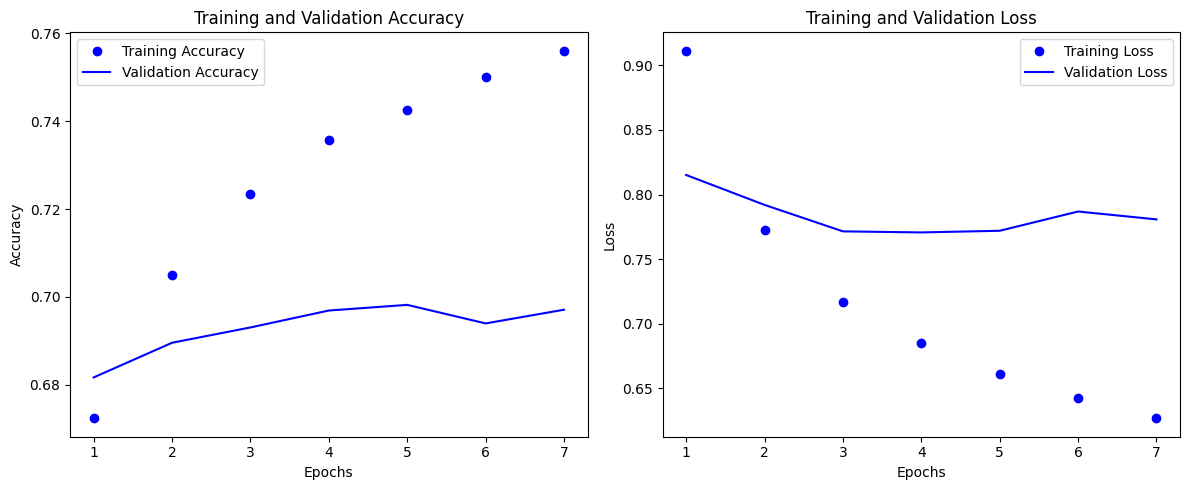

In [25]:
# Plot the training and validation accuracy and loss over epochs to visualize the model's performance and convergence.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Approach LSTM - EarlyStopping

In [19]:
embedding_dim = 128
lstm_units = 30  
num_classes = labels.shape[1]

In [20]:
# Building the model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))  # Added Dropout layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))  # Added L2 regularization

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [23]:
# Train the model with early stopping
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10


1534/1534 [==============================] - 913s 593ms/step - loss: 0.9114 - accuracy: 0.6724 - val_loss: 0.8152 - val_accuracy: 0.6817
Epoch 2/10
1534/1534 [==============================] - 1016s 662ms/step - loss: 0.7726 - accuracy: 0.7050 - val_loss: 0.7920 - val_accuracy: 0.6896
Epoch 3/10
1534/1534 [==============================] - 1079s 703ms/step - loss: 0.7169 - accuracy: 0.7234 - val_loss: 0.7715 - val_accuracy: 0.6931
Epoch 4/10
1534/1534 [==============================] - 1045s 681ms/step - loss: 0.6847 - accuracy: 0.7356 - val_loss: 0.7707 - val_accuracy: 0.6969
Epoch 5/10
1534/1534 [==============================] - 1021s 666ms/step - loss: 0.6609 - accuracy: 0.7425 - val_loss: 0.7720 - val_accuracy: 0.6982
Epoch 6/10
1534/1534 [==============================] - 1042s 679ms/step - loss: 0.6421 - accuracy: 0.7501 - val_loss: 0.7869 - val_accuracy: 0.6940
Epoch 7/10
1534/1534 [==============================] - 1152s 751ms/step - loss: 0.6267 - accuracy: 0.756

### Evaluating the Model

In [31]:
# Evaluate the model's performance on the test set and print out the test accuracy as a percentage.
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

427/427 [==============================] - 38s 89ms/step - loss: 0.7770 - accuracy: 0.6986
Test Accuracy: 69.86%


In [27]:
# Making predictions 
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

427/427 [==============================] - 39s 90ms/step


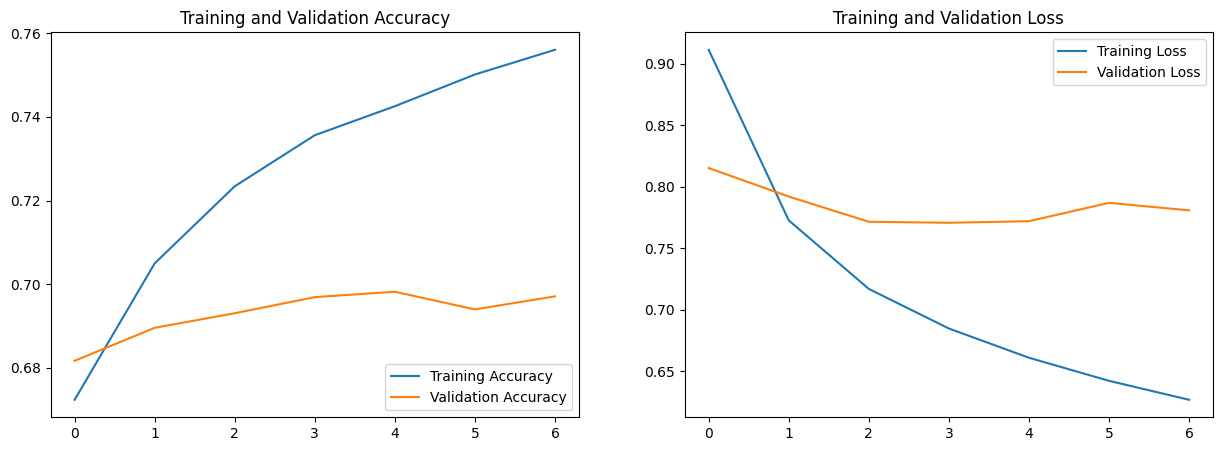

In [29]:
# Plotting training and validation accuracy and loss over epochs to assess model performance.
# The figure consists of two subplots: one for accuracy and another for loss, each with training and validation curves.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()